# AutoML percentile correction on M5 (XGBoost)

This version selects percentiles by overall **MSE** (metric mode).


In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from utilsforecast.losses import mse, rmse

from datasetsforecast.m5 import M5
from mlforecast.auto import xgboost_space
import optuna

def eval_metrics(valid_df: pd.DataFrame, preds_df: pd.DataFrame, model_col: str) -> dict:
    merged = valid_df.merge(preds_df, on=['unique_id', 'ds'], how='inner')
    err = merged[model_col] - merged['y']
    return {
        'rows': len(merged),
        'rmse': float(np.sqrt(np.mean(np.square(err)))),
        'mse': float(np.mean(np.square(err))),
        'bias': float(np.mean(err)),
    }

def mse_loss(df, train_df):  # train_df is unused here
    # df has columns: ['unique_id', 'ds', 'cutoff', 'y', 'model']
    return mse(df, models=['model'], id_col='unique_id', target_col='y')['model'].mean()


/Users/janrathfelder/miniconda3/envs/mlforecast-dev/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = 'data'
M5.download(data_dir)
Y_df, X_df, S_df = M5.load(directory=data_dir)
df = Y_df.copy()
df['ds'] = pd.to_datetime(df['ds'])

# Optional: subsample ids for faster experiments
MAX_IDS = 5000
all_ids = df['unique_id'].unique()
if MAX_IDS is not None and len(all_ids) > MAX_IDS:
    rng = np.random.default_rng(0)
    keep_ids = rng.choice(all_ids, size=MAX_IDS, replace=False)
    df = df[df['unique_id'].isin(keep_ids)].copy()

h = 28
season_length = 7

# Percentile levels used for correction (customizable)
CORRECTION_LEVELS = list(range(5, 100, 5))

n_windows = 2
num_samples = 1  # increase for stronger tuning
optimize_kwargs = {'timeout': 300}


In [3]:
def rolling_holdout_splits(df, h, n_test_sets, time_col='ds'):
    # assume all ids share same ds grid
    all_ds = pd.to_datetime(sorted(df[time_col].unique()))
    max_ds = all_ds[-1]
    step = pd.Timedelta(days=h)

    for k in range(n_test_sets):
        test_end = max_ds - k * step
        test_start = test_end - pd.Timedelta(days=h - 1)

        train = df[df[time_col] < test_start]
        test = df[(df[time_col] >= test_start) & (df[time_col] <= test_end)]

        yield k, train.reset_index(drop=True), test.reset_index(drop=True)


In [4]:
def tweedie_space(trial):
    params = xgboost_space(trial)
    params["objective"] = "reg:tweedie"
    params["tweedie_variance_power"] = 1.5
    params["eval_metric"] = "tweedie-nloglik@1.5"
    return params


In [5]:
from sklearn.preprocessing import FunctionTransformer
from mlforecast.target_transforms import LocalStandardScaler, GlobalSklearnTransformer

from mlforecast.lag_transforms import (RollingMean, ExponentiallyWeightedMean, ExpandingMax, ExpandingMin,
                                       RollingStd)

LAGS = [
    [1],
    [1, 2, 3],
    [1, 2, 3, 7],
    [1, 7, 14],
    [1, 7, 14, 28],
    [1, season_length],
    [1, season_length, 2 * season_length],
]

LAG_TRANSFORMS = [
    {1: [ExponentiallyWeightedMean(0.9),
         ExpandingMax(),
         ExpandingMin(),
         RollingStd(window_size=3, min_samples=1),
         RollingStd(window_size=8, min_samples=3),
         RollingMean(window_size=3, min_samples=1),
         RollingMean(window_size=8, min_samples=3)
         ]
     },
   # {
   #     1: [ExponentiallyWeightedMean(0.9)],
   #     7: [RollingMean(window_size=3, min_samples=1)],
   # },
]

DATE_FEATURES = ["year", "month", "week", "weekday"]  # standard calendar features

def my_init_config(trial):
    lags_idx = trial.suggest_int("lags_idx", 0, len(LAGS) - 1)
    ltfm_idx = trial.suggest_int("lag_tfms_idx", 0, len(LAG_TRANSFORMS) - 1)
    return {
        "target_transforms": None,   # no differencing
        "lags": LAGS[lags_idx],
        "lag_transforms": LAG_TRANSFORMS[ltfm_idx],
        "date_features": None,
    }


In [7]:
def my_fit_config(trial):
    return {
        "dropna": False,
    }
    
n_test_sets = 1
h = 28

rmse_base_test = []
bias_base_test = []

rmse_corr_test = []
bias_corr_test = []

cv_rmse_normal_cv = []
cv_bias_normal_cv = []

cv_rmse_corr_cv = []
cv_bias_corr_cv = []

share_correction = []
p_val_cv = []

for i, train_i, test_i in rolling_holdout_splits(df, h, n_test_sets):
    from mlforecast.auto import AutoMLForecast, AutoXGBoost, PredictionIntervals
    
    auto_base = AutoMLForecast(
    models={"xgb": AutoXGBoost(config=tweedie_space)},
    freq="D",
    init_config=my_init_config,
    fit_config=my_fit_config,
    # reuse_cv_splits=True
    )

    auto_corr = AutoMLForecast(
        models={"xgb": AutoXGBoost(config=tweedie_space)},
        freq="D",
        init_config=my_init_config,
        fit_config=my_fit_config,
        # reuse_cv_splits=True
    )
    
    print(i, train_i.ds.min(), train_i.ds.max(), " | ", 
          test_i.ds.min(), test_i.ds.max())

    length_ids = train_i.groupby('unique_id').ds.nunique().reset_index()

    good_ids = length_ids[length_ids.ds > 55].unique_id.unique()

    train_i = train_i[train_i.unique_id.isin(good_ids)].copy()
    test_i = test_i[test_i.unique_id.isin(good_ids)].copy()
    
    study_kwargs = {"sampler": optuna.samplers.TPESampler()} 
    # Train base model:
    auto_base.fit(
    df=train_i,
    n_windows=n_windows,
    h=h,
    num_samples=num_samples,
    optimize_kwargs=optimize_kwargs,
    step_size=5,
    loss=mse_loss,
    study_kwargs={"sampler": optuna.samplers.TPESampler()}
    # prediction_intervals=PredictionIntervals(n_windows=n_windows, h=h),
    )

    preds_base = auto_base.predict(h=test_i.ds.nunique())
    metrics_base = eval_metrics(test_i, preds_base, "xgb")
    
    # Train corrected model:
    auto_corr.fit(
    df=train_i,
    n_windows=n_windows,
    h=h,
    num_samples=num_samples,
    step_size=5,
    optimize_kwargs=optimize_kwargs,
    prediction_intervals=PredictionIntervals(n_windows=2, h=h),
    percentile_correction=True,
    percentile_correction_mode="metric",
    percentile_correction_metric="mse",
    percentile_correction_levels=CORRECTION_LEVELS,
    compute_corrected_cv_metrics=True,
    loss=mse_loss,
    study_kwargs={"sampler": optuna.samplers.TPESampler()}
    )

    preds_corr = auto_corr.predict(h=test_i.ds.nunique())
    metrics_corr = eval_metrics(test_i, preds_corr, "xgb")
    
    rmse_base = metrics_base['rmse']
    bias_base = metrics_base['rmse']
    
    rmse_corr = metrics_corr['rmse']
    bias_corr = metrics_corr['rmse']
    
    cv_rmse_normal = auto_corr.cv_metrics_["xgb"]['rmse']
    cv_bias_normal = auto_corr.cv_metrics_["xgb"]['bias']
    
    cv_rmse_corr = auto_corr.cv_metrics_corrected_["xgb"]['rmse']
    cv_bias_corr = auto_corr.cv_metrics_corrected_["xgb"]['bias']
    
    #############
    # save outputs
    rmse_base_test.append(rmse_base)
    bias_base_test.append(bias_base)
    
    rmse_corr_test.append(rmse_base)
    bias_corr_test.append(bias_base)
    
    cv_rmse_normal_cv.append(cv_rmse_normal)
    cv_bias_normal_cv.append(cv_bias_normal)
    
    cv_rmse_corr_cv.append(cv_rmse_corr)
    cv_bias_corr_cv.append(cv_bias_corr)
    ###############
    # Get base and corrected forecast from correction model:
    name = "xgb"
    corr = auto_corr.percentile_correction_[name]
    corr_ids = list(corr["id_to_col"].keys())

    # raw predictions WITH the needed percentile columns
    raw_preds = auto_corr.models_[name].predict(
        h=test_i.ds.nunique(),
        level=corr["levels"],  # make sure percentile cols exist
    )

    # corrected predictions (auto_corr.predict applies correction)
    preds_optimal = auto_corr.predict(h=test_i.ds.nunique())
    ###############
    preds_all = raw_preds.merge(preds_optimal, on=['ds', 'unique_id'])
    
    corr_ids_str = set(map(str, corr_ids))
    preds_all = preds_all[preds_all.unique_id.astype(str).isin(corr_ids_str)]
    
    preds_all = preds_all.merge(test_i, on=['ds', 'unique_id'])

    preds_all['res_base'] = abs(preds_all.xgb_x - preds_all.y)
    preds_all['res_best'] = abs(preds_all.xgb_y - preds_all.y)

    preds_all['flag'] = np.where(preds_all.res_best < preds_all.res_base, 1, 0)
    share_correction.append(preds_all['flag'].mean())
    #############
    # Run t-test:
    t_stat, p_val = stats.ttest_ind(preds_all.xgb_x, 
                                preds_all.xgb_y, 
                                equal_var=True)  
    p_val_cv.append(p_val)



[I 2026-02-22 00:17:08,858] A new study created in memory with name: no-name-27cd20d6-dc01-4797-8654-85ef360d11da


0 1 2606  |  2607 2610


[I 2026-02-22 00:17:19,996] Trial 0 finished with value: 415.34990872664423 and parameters: {'n_estimators': 826, 'max_depth': 9, 'learning_rate': 0.010934750848426109, 'subsample': 0.8889682219473886, 'colsample_bytree': 0.22590351770165212, 'reg_lambda': 7.820773445372115e-06, 'reg_alpha': 0.039989630054455494, 'min_child_weight': 4, 'lags_idx': 4, 'lag_tfms_idx': 0}. Best is trial 0 with value: 415.34990872664423.
[I 2026-02-22 00:17:30,630] A new study created in memory with name: no-name-fee5bb89-5d50-4c7e-b5b7-250e92f5cfe1
[I 2026-02-22 00:17:38,962] Trial 0 finished with value: 411.5448227703264 and parameters: {'n_estimators': 940, 'max_depth': 7, 'learning_rate': 0.015080154674669295, 'subsample': 0.8353707825068434, 'colsample_bytree': 0.3089785845673599, 'reg_lambda': 0.00017128222970569002, 'reg_alpha': 0.4529707787885953, 'min_child_weight': 2, 'lags_idx': 0, 'lag_tfms_idx': 0}. Best is trial 0 with value: 411.5448227703264.


In [12]:
raw_preds.ds.min()

np.int64(94)

In [11]:
test_i.ds.nunique()

4

In [8]:
test_i.ds.min()

np.int64(2607)

In [10]:
preds_base.ds.max()

np.int64(2610)

In [23]:
preds_all.head(1)

,unique_id,ds,xgb_x,xgb-lo-15,xgb-lo-10,xgb-lo-5,xgb-lo-1,xgb-hi-1,xgb-hi-5,xgb-hi-10,xgb-hi-15,xgb_y
0,W1,2193,37235.707031,36560.744297,36785.731875,37010.719453,37190.709516,37280.704547,37460.694609,37685.682188,37910.669766,36560.746094


In [8]:
share_correction

[nan, nan, nan]

In [21]:
preds_all = raw_preds.merge(preds_optimal, on=['ds', 'unique_id'])

In [22]:
corr_ids_str = set(map(str, corr_ids))
preds_all = preds_all[preds_all.unique_id.astype(str).isin(corr_ids_str)]

In [17]:
preds_all = preds_all.merge(test_i, on=['ds', 'unique_id'])

In [18]:
preds_all.head()

,unique_id,ds,xgb_x,xgb-lo-15,xgb-lo-10,xgb-lo-5,xgb-lo-1,xgb-hi-1,xgb-hi-5,xgb-hi-10,xgb-hi-15,xgb_y,y


In [84]:


# two independent samples
t_stat, p_val = stats.ttest_ind(preds_corr.xgb, 
                                preds_base.xgb, 
                                equal_var=True)  

print("t =", t_stat, "p =", p_val)  

t = 0.006326560092236827 p = 0.9949523042838517


{'rmse': 870.1625182757776, 'bias': 90.272621545321}

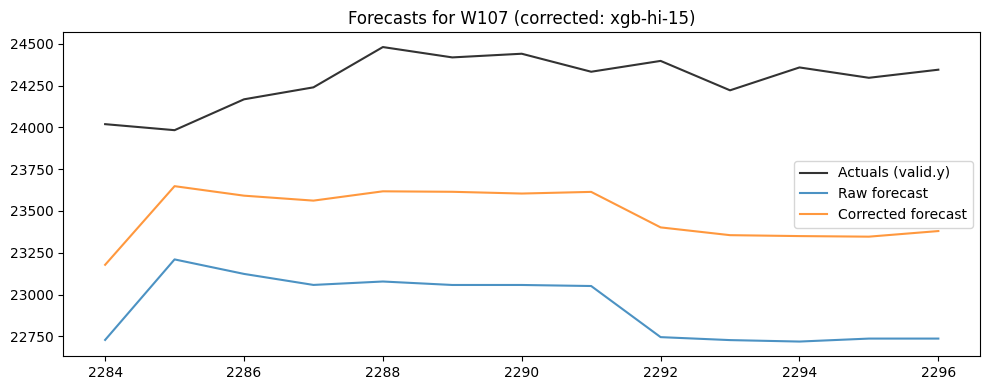

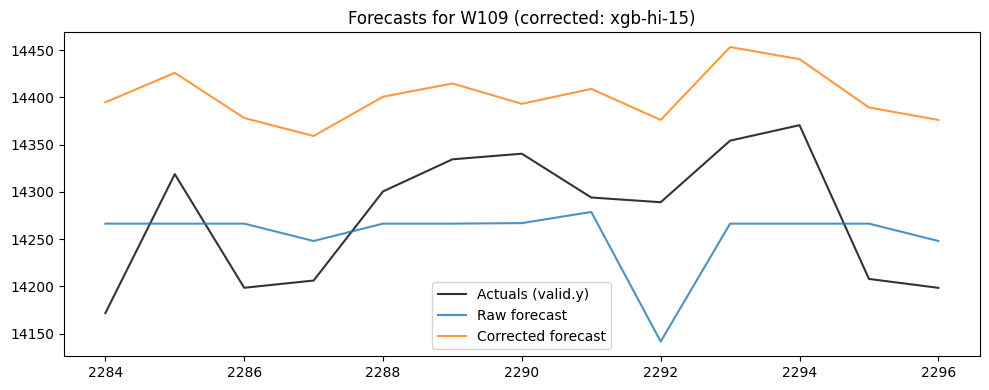

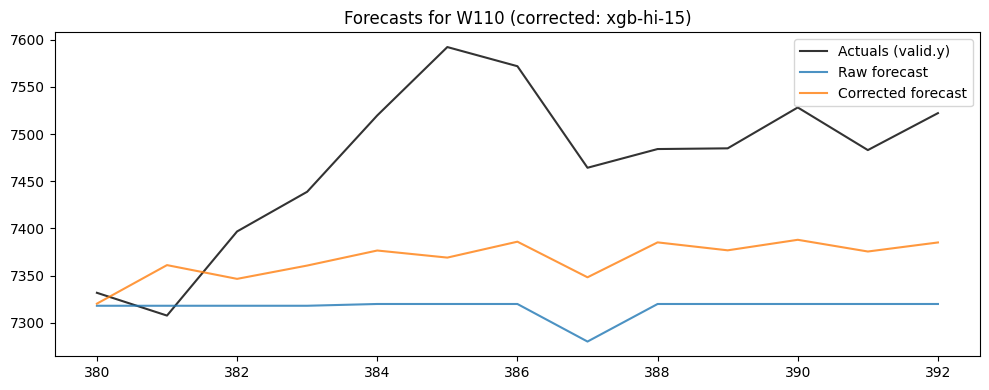

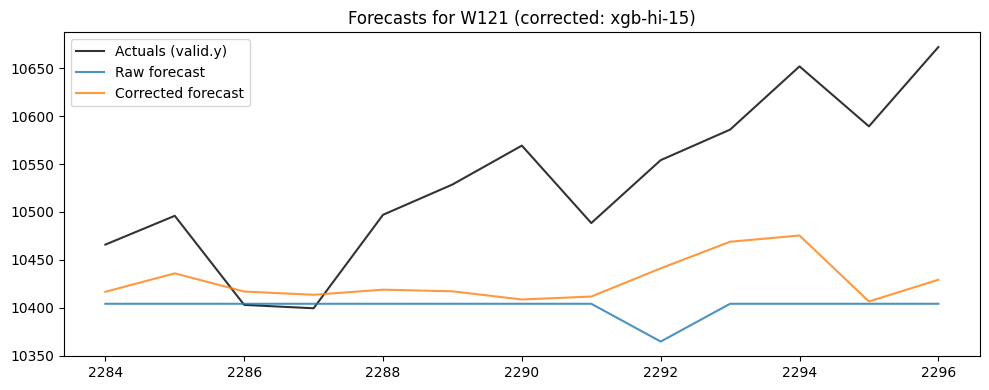

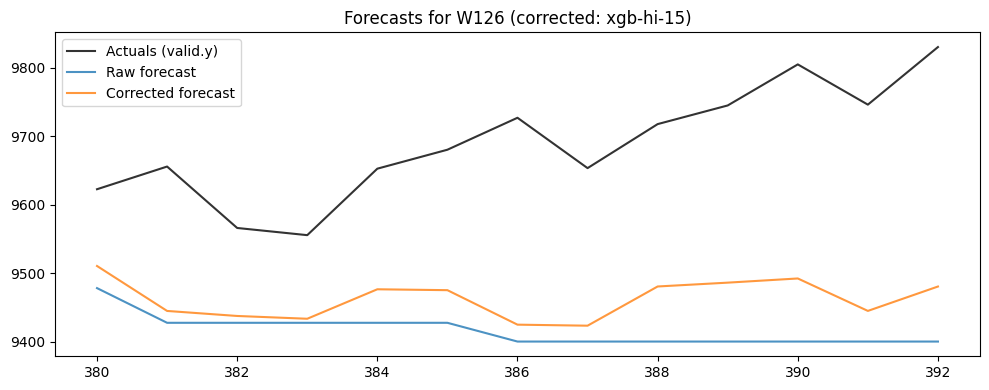

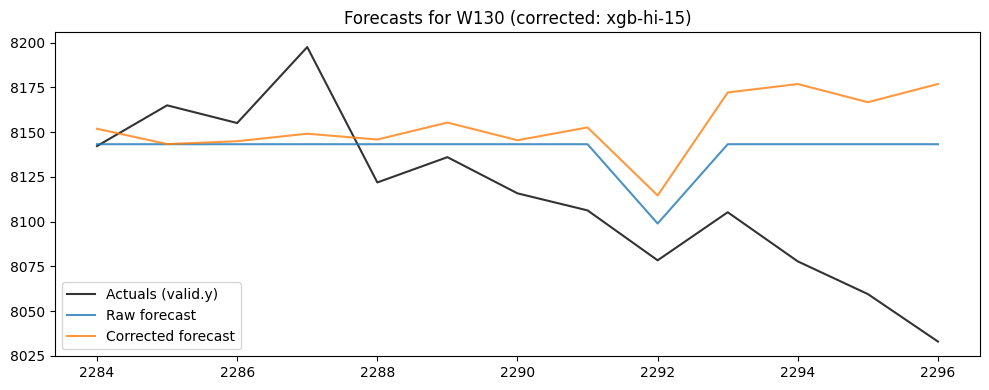

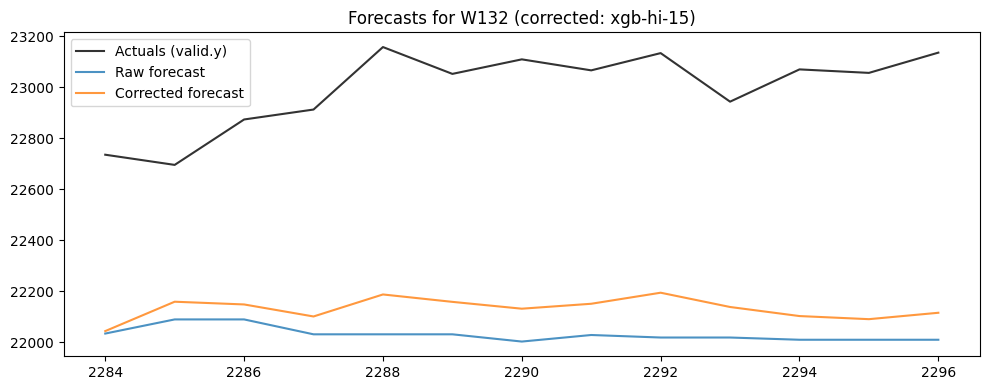

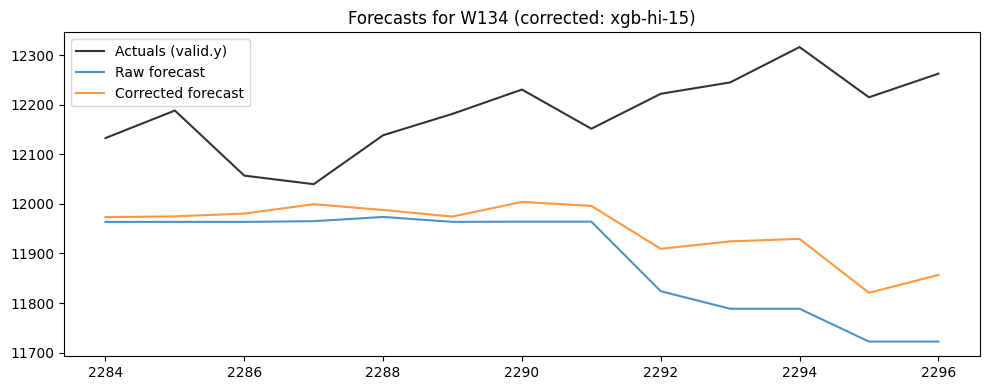

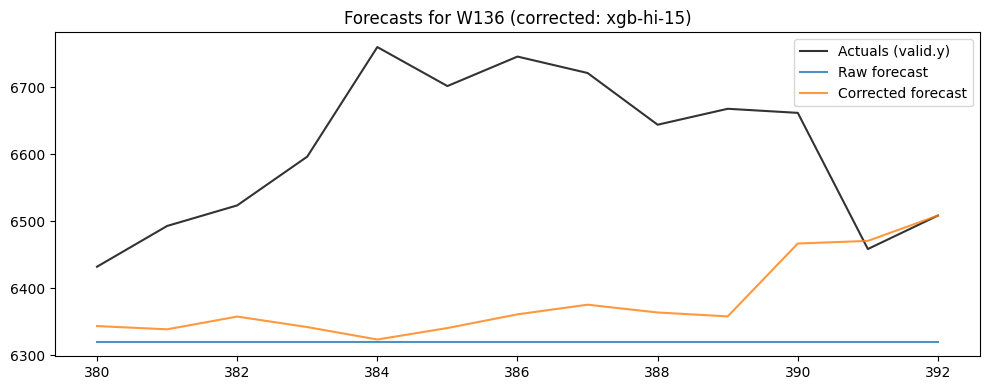

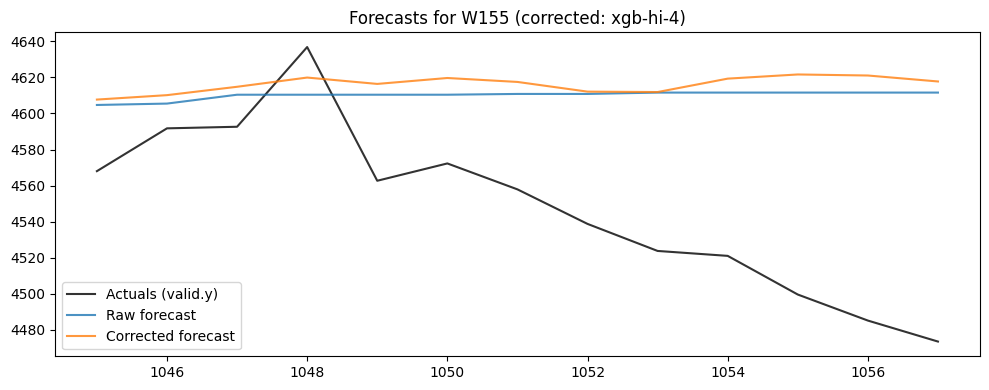

In [51]:
import matplotlib.pyplot as plt

name = "xgb"
corr = auto_corr.percentile_correction_[name]
corr_ids = list(corr["id_to_col"].keys())

# raw predictions WITH the needed percentile columns
raw_preds = auto_corr.models_[name].predict(
    h=h,
    level=corr["levels"],  # make sure percentile cols exist
)

# corrected predictions (auto_corr.predict applies correction)
corr_preds = auto_corr.predict(h=h)

for uid in corr_ids[0:10]:
    raw_uid = raw_preds[raw_preds["unique_id"] == uid]
    corr_uid = corr_preds[corr_preds["unique_id"] == uid]
    valid_uid = valid[valid["unique_id"] == uid]

    if raw_uid.empty or corr_uid.empty or valid_uid.empty:
        continue

    plt.figure(figsize=(10, 4))
    plt.plot(valid_uid["ds"], valid_uid["y"], label="Actuals (valid.y)", color="black", alpha=0.8)
    plt.plot(raw_uid["ds"], raw_uid[name], label="Raw forecast", alpha=0.8)
    plt.plot(corr_uid["ds"], corr_uid[name], label="Corrected forecast", alpha=0.8)
    plt.title(f"Forecasts for {uid} (corrected: {corr['id_to_col'][uid]})")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
preds_all = raw_preds.merge(corr_preds, on=['ds', 'unique_id'])

preds_all = preds_all.merge(valid, on=['ds', 'unique_id'])

preds_all['res_base'] = abs(preds_all.xgb_x - preds_all.y)
preds_all['res_best'] = abs(preds_all.xgb_y - preds_all.y)

preds_all['flag'] = np.where(preds_all.res_best < preds_all.res_base, 1, 0)

preds_all.head()

,unique_id,ds,xgb_x,xgb-lo-15,xgb-lo-12,xgb-lo-9,xgb-lo-4,xgb-lo-1,xgb-hi-1,xgb-hi-4,xgb-hi-9,xgb-hi-12,xgb-hi-15,xgb_y,y
0,W1,2180,38359.558594,38321.695734,38329.268306,38336.840878,38349.461831,38357.034403,38362.082784,38369.655356,38382.276309,38389.848881,38397.421453,38359.558594,35397.16
1,W1,2181,37928.027344,37869.779203,37881.428831,37893.078459,37912.494506,37924.144134,37931.910553,37943.560181,37962.976228,37974.625856,37986.275484,37928.027344,35808.59
2,W1,2182,38337.835938,38233.434672,38254.314925,38275.195178,38309.995600,38330.875853,38344.796022,38365.676275,38400.476697,38421.356950,38442.237203,38337.835938,35808.59
3,W1,2183,38705.902344,38440.468578,38493.555331,38546.642084,38635.120006,38688.206759,38723.597928,38776.684681,38865.162603,38918.249356,38971.336109,38705.902344,36246.14
4,W1,2184,38644.234375,38617.612867,38622.937169,38628.261470,38637.135306,38642.459608,38646.009142,38651.333444,38660.207280,38665.531581,38670.855883,38644.234375,36246.14


In [53]:
preds_all['res_base'] = abs(preds_all.xgb_x - preds_all.y)
preds_all['res_best'] = abs(preds_all.xgb_y - preds_all.y)

preds_all['flag'] = np.where(preds_all.res_best < preds_all.res_base, 1, 0)

In [54]:
preds_all[preds_all.unique_id.isin(corr_ids)].flag.describe()

count    1079.000000
mean        0.565338
std         0.495942
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: flag, dtype: float64

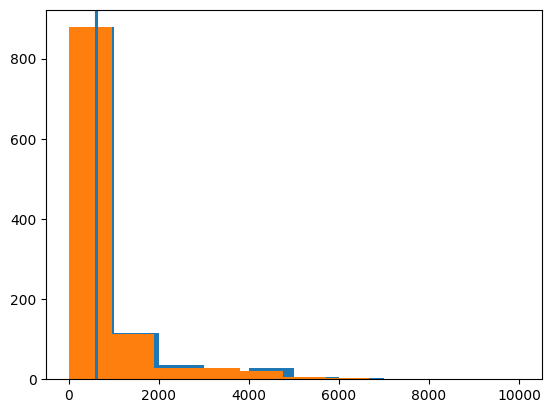

In [55]:
plt.hist(preds_all[preds_all.unique_id.isin(corr_ids)].res_base)
plt.axvline(preds_all[preds_all.unique_id.isin(corr_ids)].res_base.mean())
plt.hist(preds_all[preds_all.unique_id.isin(corr_ids)].res_best)
plt.axvline(preds_all[preds_all.unique_id.isin(corr_ids)].res_best.mean())

In [56]:
from utilsforecast.losses import rmse, mae
import pandas as pd

name = "xgb"
corr = auto_corr.percentile_correction_[name]
corr_ids = list(corr["id_to_col"].keys())

# raw preds with percentile columns
raw_preds = auto_corr.models_[name].predict(h=h, level=corr["levels"])
corr_preds = auto_corr.predict(h=h)

# optional: unshift if trained on y_pos
# raw_preds = unshift_preds(raw_preds, offset_by_id, name)
# corr_preds = unshift_preds(corr_preds, offset_by_id, name)

# restrict to corrected ids
valid_sub = valid[valid["unique_id"].isin(corr_ids)]
raw_sub = raw_preds[raw_preds["unique_id"].isin(corr_ids)]
corr_sub = corr_preds[corr_preds["unique_id"].isin(corr_ids)]

# merge for eval
raw_eval = valid_sub.merge(raw_sub, on=["unique_id", "ds"], how="inner")
corr_eval = valid_sub.merge(corr_sub, on=["unique_id", "ds"], how="inner")

# RMSE from utilsforecast
rmse_raw = rmse(raw_eval, models=[name], id_col="unique_id", target_col="y")[name].mean()
rmse_corr = rmse(corr_eval, models=[name], id_col="unique_id", target_col="y")[name].mean()

# Bias (mean error)
bias_raw = (raw_eval[name] - raw_eval["y"]).mean()
bias_corr = (corr_eval[name] - corr_eval["y"]).mean()

pd.DataFrame([
    {"run": "raw_corrected_ids", "rmse": rmse_raw, "bias": bias_raw},
    {"run": "corrected_corrected_ids", "rmse": rmse_corr, "bias": bias_corr},
]).set_index("run")


,rmse,bias
run,,
raw_corrected_ids,735.572360,-181.96613
corrected_corrected_ids,710.275511,-178.96178
